In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
def readFinancialData(name):
    df = pd.read_csv(f'FinancialData/{name}.csv')
    df = df.set_index('Date')
    if 'Code' in df.columns:
        df = df.drop('Code', axis=1)
    return df.drop(df[df.eq(0).all(axis=1)].index)

In [3]:
def readAE_pred(name):
    df = readFinancialData(f'{name}_AE_pred')
    df_mean = df['Mean'].apply(lambda x: pd.Series([float(i) for i in x[1:-1].split()]))
    df_mean = df_mean.apply(lambda x: x+1).cumprod(axis=1)
    df = pd.concat([df_mean,df[['Variance','Predicted return']]],axis=1)
    df_bool = df.applymap(lambda x: x > 1.4e+8)
    df = df[~df_bool.any(axis=1)]
    return df

In [4]:
def checknan(X):
    for col in X.columns:
        for value in list(X[col].items()):
            if np.isnan(value[1]):
                print(col,value[0])
            if value[1] > 3.4e+38:
                print(f'nan in {col}')

In [5]:
def getLabels(df,n):
    df_y = pd.DataFrame(index=df.index)
    for i in range(n):
        y = (df['Close'].shift(-i-1) / df['Close'])
        y.name = f'Label_{i+1}'
        df_y[y.name] = y
    return df_y

In [6]:
def reduceXy(X, y):
    y = y.loc[X.index].dropna()
    X = X.loc[y.index]
    print(X.shape[0],y.shape[0])
    return (X, y)

In [7]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# print(f"Using {device} device")

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 15),
        )

    def forward(self, input):
        logits = self.linear_relu_stack(input)
        return logits

In [9]:
def getTensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

## Main

SPX
429 429
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


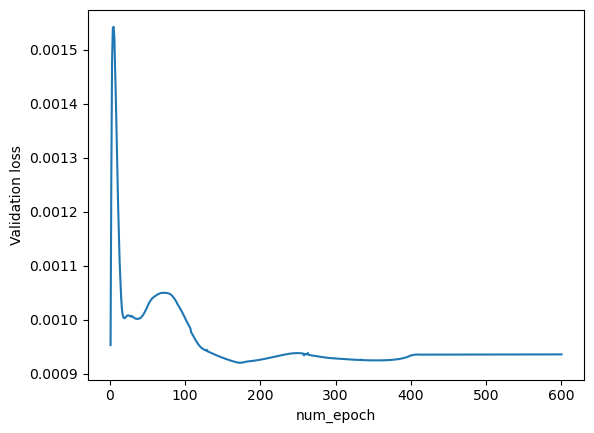

NKX
429 429
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


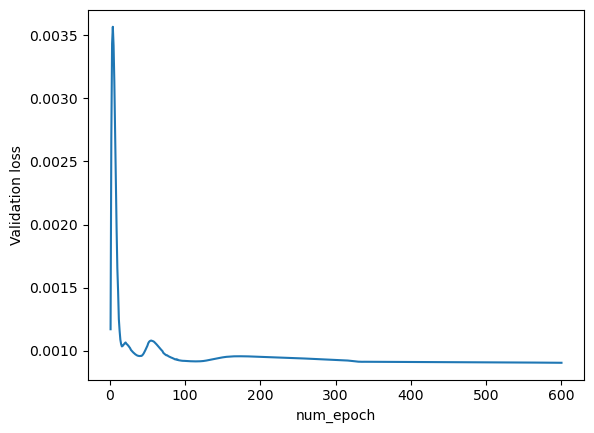

2YUSY
429 429
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


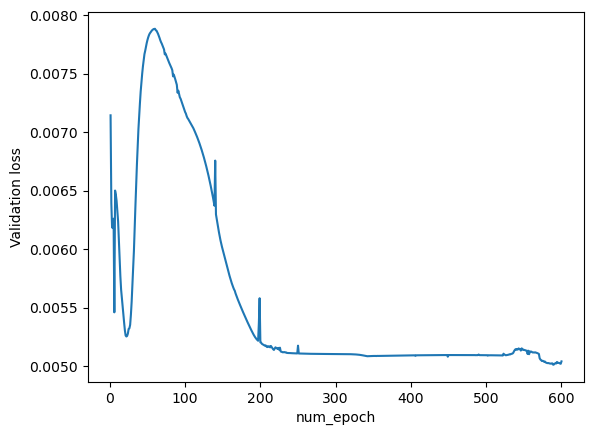

10YUSY
429 429
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


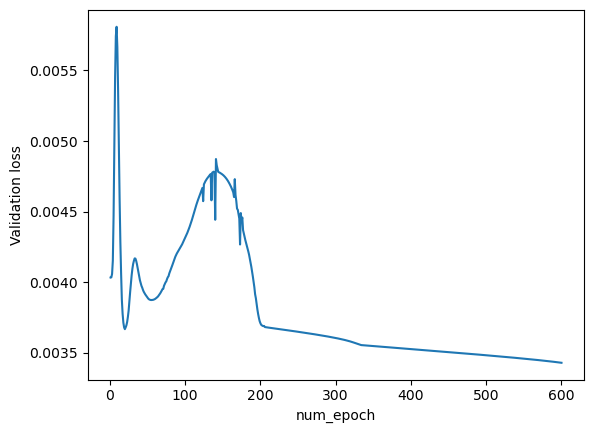

USDEUR
416 416
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


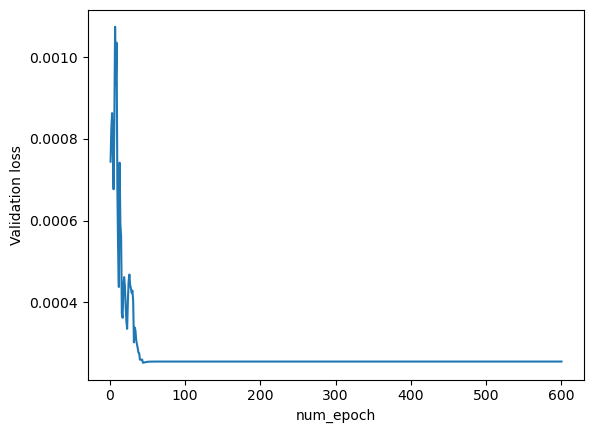

USDJPY
422 422
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


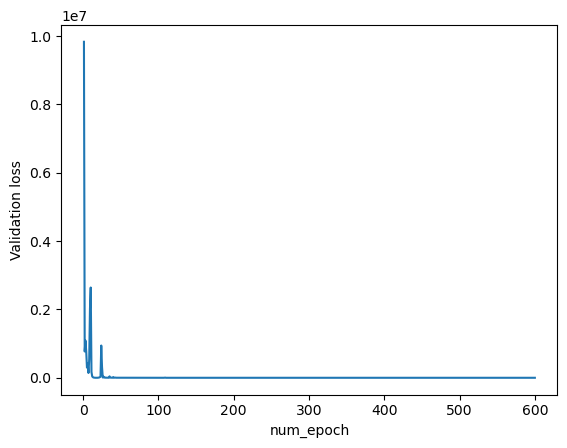

BTCUSD
429 429
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


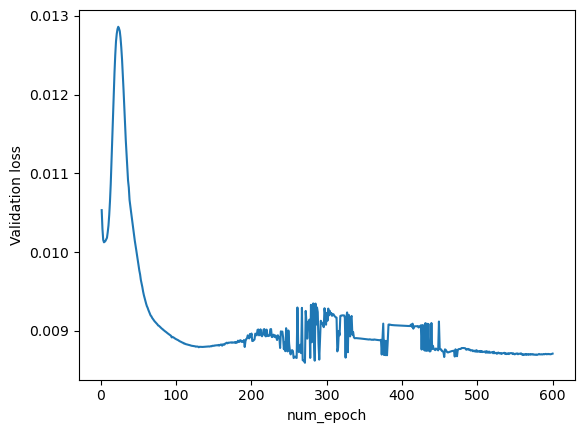

ETH
429 429
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 Finished Training


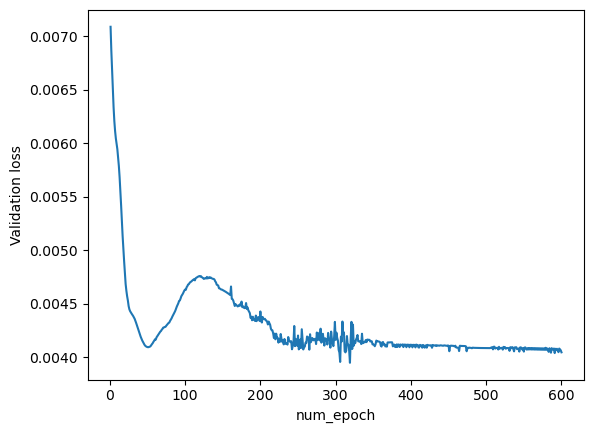

In [25]:
tickers = 'SPX,NKX,2YUSY,10YUSY,USDEUR,USDJPY,BTCUSD,ETH'
for ticker in tickers.split(','):
    print(ticker)
    
    #load df_ae_pred
    df_ae_pred = readAE_pred(ticker)

    checknan(df_ae_pred)
    
    #load df_pred (predictions of random forest)
    df_pred = readFinancialData(f'{ticker}_pred')
    
    #load df_raw 
    df_raw = readFinancialData(ticker)
    
    #create labels dataframe
    df_y = getLabels(df_raw,15)
    
    #create X dataframe
    common_index = df_ae_pred.index.intersection(df_pred.index)
    df_com_pred = pd.concat([df_ae_pred.loc[common_index],df_pred.loc[common_index]],axis=1)
    checknan(df_com_pred)
    #print(df_com_pred.iloc[0])
    
    #matching X y length
    X, y = reduceXy(df_com_pred, df_y)
    
    #create train and validation dataset
    dataset = TensorDataset(getTensor(X), getTensor(y))

    train_size = int(0.8 * len(dataset))
    validation_size = len(dataset) - train_size
    train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

    train_loader = DataLoader(train_dataset)
    validation_loader = DataLoader(validation_dataset)
    
    #define model
    model = NeuralNetwork()
    
    #training
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    epochs = 600
    loss_list = []
    val_loss_list = []
    
    for epoch in range(epochs):
        if epoch % 10 ==0:
            print(epoch,end=' ')
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Print training loss
        epoch_loss = running_loss / len(train_loader)
        loss_list.append(epoch_loss)
        #print(f"Training loss: {epoch_loss}", end=' ')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():  # Turn off gradients for validation
            for inputs, labels in validation_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

        # Print validation loss
        epoch_val_loss = running_val_loss / len(validation_loader)
        val_loss_list.append(epoch_val_loss)
        #print(f"Validation loss: {epoch_val_loss}")
    print('Finished Training')
    
    #save model
    torch.save(model, f'models/nn_{ticker}2.pt')
    
    #plot validation loss
    plt.plot(range(1,len(val_loss_list)+1),val_loss_list)
    plt.xlabel('num_epoch')
    plt.ylabel('Validation loss')
    plt.savefig(f'figures/{ticker}_ValidationLoss2.png',bbox_inches='tight')
    plt.show()
    

In [47]:
#predict for lastest day
tickers = 'SPX,NKX,2YUSY,10YUSY,USDEUR,USDJPY,BTCUSD,ETH'
dic_pred = {}
for ticker in tickers.split(','):
    print(ticker)
    
    #load df_ae_pred
    df_ae_pred = readAE_pred(ticker)

    checknan(df_ae_pred)
    
    #load df_pred (predictions of random forest)
    df_pred = readFinancialData(f'{ticker}_pred')
    
    #load df_raw 
    df_raw = readFinancialData(ticker)
    
    #create labels dataframe
    df_y = getLabels(df_raw,15)
    
    #create X dataframe
    common_index = df_ae_pred.index.intersection(df_pred.index)
    df_com_pred = pd.concat([df_ae_pred.loc[common_index],df_pred.loc[common_index]],axis=1)
    checknan(df_com_pred)
    print(df_com_pred.iloc[-1].name)
    #print(df_com_pred.iloc[0])
    
    #create X tensor
    X = torch.tensor(df_com_pred.iloc[-1].values, dtype=torch.float32).view(1,32)
    
    #get model
    model = torch.load(f'models/nn_{ticker}.pt')
    model.eval()
    
    #add into dic_pred
    dic_pred[ticker] = model(X).detach().numpy().reshape(-1).tolist()

SPX
2023-12-15
NKX
2023-12-15
2YUSY
2023-12-15
10YUSY
2023-12-15
USDEUR
2023-12-15
USDJPY
2023-12-15
BTCUSD
2023-12-15
ETH
2023-12-15


In [48]:
dic_pred

{'SPX': [1.0042133331298828,
  1.0074454545974731,
  1.0086519718170166,
  1.0071972608566284,
  1.0062665939331055,
  1.0049595832824707,
  1.0041393041610718,
  1.0084354877471924,
  1.0064897537231445,
  1.0067540407180786,
  1.0062111616134644,
  1.0052202939987183,
  1.0046688318252563,
  1.0035264492034912,
  1.0025644302368164],
 'NKX': [1.001426339149475,
  0.9991018772125244,
  1.001373052597046,
  0.9996775984764099,
  1.0001791715621948,
  1.0002129077911377,
  0.9998658299446106,
  0.9988505244255066,
  0.9992351531982422,
  1.0025736093521118,
  1.0017427206039429,
  1.0016067028045654,
  1.0021313428878784,
  1.0018638372421265,
  1.0015697479248047],
 '2YUSY': [0.9996762275695801,
  0.9973750114440918,
  0.998511552810669,
  0.9956330060958862,
  0.9980739951133728,
  1.0000396966934204,
  1.0028233528137207,
  1.0049209594726562,
  1.0060358047485352,
  1.0056099891662598,
  1.0065584182739258,
  1.0080634355545044,
  1.0106127262115479,
  1.0114061832427979,
  1.012352